# Image Data pytorch 커스터마이징하기

In [ ]:
# !pip install --upgrade torch torchvision

In [1]:
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os

import glob
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
  torch.cuda.manual_seed_all(777)

In [3]:
# 경로지정

train_path = './train'
test_path = './test'

Dataset_path = '.'

belt_dir = '/belt/'
eyewear_dir = '/eyewear/'
hat_dir = '/hat/'
long_sleeve_dir = '/long_sleeve/'
pants_dir = '/pants/'
short_sleeve_dir = '/short_sleeve/'
sneakers_dir = '/sneakers/'
watch_dir = '/watch/'
bags_dir = '/bags/'

## 1. 이미지 resize & 스케일링

* 꼭 resize를 진행한 이미지들을 스케일링 해줍니다.

In [4]:
resize_trans = transforms.Compose([
                                   transforms.Resize((128,128)),
                                   transforms.ToTensor()
    
])


resize_train = torchvision.datasets.ImageFolder(root=train_path,transform=resize_trans)
resize_test = torchvision.datasets.ImageFolder(root=test_path,transform=resize_trans)

In [5]:
resize_train

Dataset ImageFolder
    Number of datapoints: 8569
    Root location: ./train
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
           )

In [6]:
train_loader = DataLoader(resize_train, batch_size=32, shuffle=True)
test_loader = DataLoader(resize_test, batch_size=32, shuffle=False)

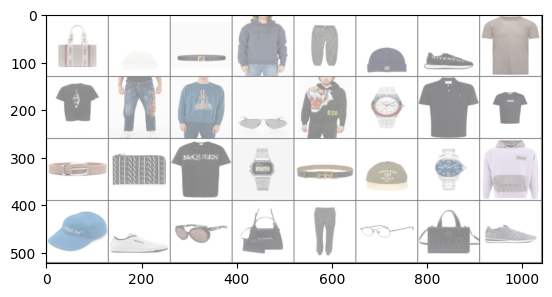

In [7]:
import matplotlib.pyplot as plt

# 데이터 로더에서 한 배치만큼 이미지를 가져와 시각화
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 이미지를 그리는 함수
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(torchvision.utils.make_grid(images))

In [8]:
resize_train[0][0].shape # ToTensor를 진행했기 때문에 데이터가 torch(C,H,W) 형태로 바뀜

torch.Size([3, 128, 128])

In [9]:
resize_train[0][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [10]:
import numpy as np
np.mean(resize_train[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB m

array([0.93457556, 0.93477285, 0.93482184], dtype=float32)

In [11]:
import numpy as np
np.mean(resize_test[0][0].numpy(),axis=(1,2)) # numpy로 바꾸고, axis = 1,2 mean으로 RGB m

array([0.7898308, 0.7829927, 0.7828494], dtype=float32)

In [12]:
def get_mean_std(dataset):
    meanRGB = [np.mean(image.numpy(), axis=(1,2)) for image,_ in dataset]
    stdRGB = [np.std(image.numpy(), axis=(1,2)) for image,_ in dataset]

    meanR = np.mean([m[0] for m in meanRGB])
    meanG = np.mean([m[1] for m in meanRGB])
    meanB = np.mean([m[2] for m in meanRGB])

    stdR = np.mean([s[0] for s in stdRGB])
    stdG = np.mean([s[1] for s in stdRGB])
    stdB = np.mean([s[2] for s in stdRGB])

    print(meanR, meanG, meanB)
    print(stdR, stdG, stdB)

In [13]:
#get_mean_std(resize_train)

In [14]:
#get_mean_std(resize_test)

In [15]:
# normalization 준비

resize_train_mean=[0.813236, 0.80471814, 0.8020124]
resize_train_std=[0.24796943, 0.25505683, 0.2579922]

resize_test_mean=[0.81307846, 0.80461836, 0.8013099]
resize_test_std=[0.24844553, 0.25523186, 0.25810322]

# 3. transform을 이용해 data augmentation하기

In [204]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)), # 이미지 resize
    transforms.RandomCrop(124), # 이미지를 랜덤으로 크롭
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 지터링(밝기, 대조, 채비, 색조)
    transforms.RandomHorizontalFlip(p = 1), # p확률로 이미지 좌우반전
    transforms.RandomVerticalFlip(p = 1), # p확률로 상하반전
    transforms.ToTensor(),
    transforms.Normalize(resize_train_mean, resize_train_std)
])

transform_test = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor(),
    transforms.Normalize(resize_test_mean, resize_test_std)
])

trainset = torchvision.datasets.ImageFolder(root=train_path, transform=transform_train)
testset = torchvision.datasets.ImageFolder(root=test_path, transform=transform_test)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)

test_loader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

In [205]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape)


torch.Size([256, 3, 124, 124])


In [206]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()


none_trans = torchvision.datasets.ImageFolder(root=train_path, transform=None)

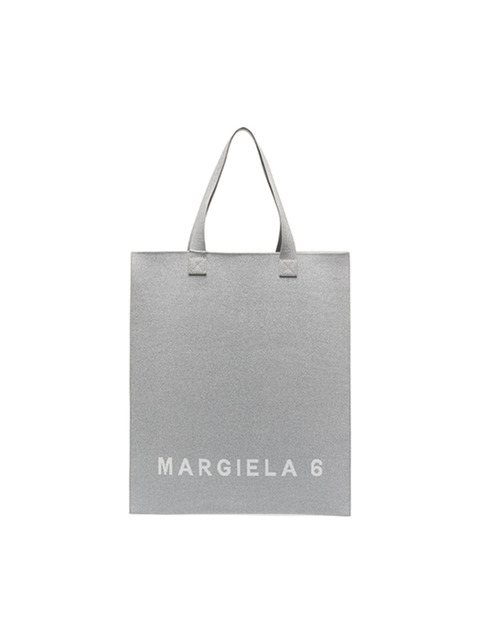

In [207]:
#원본 이미지
none_trans[0][0]

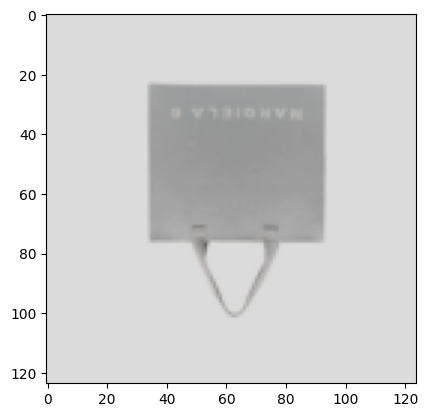

In [208]:
# augmentation을 적용한 이미지
imshow((trainset[0][0]),resize_train_mean,resize_train_std)

# albumentaion 라이브러리를 이요한 이미지 데이터 커스터마이징

In [209]:
import glob
from torch.utils.data import Dataset, DataLoader # 데이터 커스터마이징
from PIL import Image # PIL = Python Image Library
import cv2 # albumentation transform을 쓰려면 꼭 이 라이브러리를 이용
import tensorflow as tf

class inhovation_Dataset(Dataset):

  def __init__(self, file_path, mode, transform=None):
    self.all_data = sorted(glob.glob(os.path.join(file_path, mode, '*', '*')))
    self.transform = transform

  def __getitem__(self, index):

    if torch.is_tensor(index):        # 인덱스가 tensor 형태일 수 있으니 리스트 형태로 바꿔준다.
       index = index.tolist()

    data_path = self.all_data[index]
    #img = np.array(Image.open(data_path).convert("RGB")) # albumenatation transform을 쓰려면 cv2 라이브러리로 이미지를 읽어야 함
    image=cv2.imread(data_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # BGR -> RGB 변환

    # transform 적용
    if self.transform is not None:    
       augmented = self.transform(image=image)
       image = augmented['image'] 

    # 이미지 이름을 활용해 label 부여
    label=[]                                
    if os.path.basename(data_path).startswith("bags") == True:
        label = 0
    elif os.path.basename(data_path).startswith("belt") == True: 
        label = 1
    elif  os.path.basename(data_path).startswith("eyewear") == True: 
        label = 2
    elif  os.path.basename(data_path).startswith("hat") == True: 
        label = 3
    elif  os.path.basename(data_path).startswith("long_sleeve") == True: 
        label = 4
    elif  os.path.basename(data_path).startswith("pants") == True: 
        label = 5
    elif  os.path.basename(data_path).startswith("short_sleeve") == True: 
        label = 6
    elif  os.path.basename(data_path).startswith("sneakers") == True: 
        label = 7
    else:
        label = 8
    return image, label

  def __len__(self):
    length = len(self.all_data)
    return length

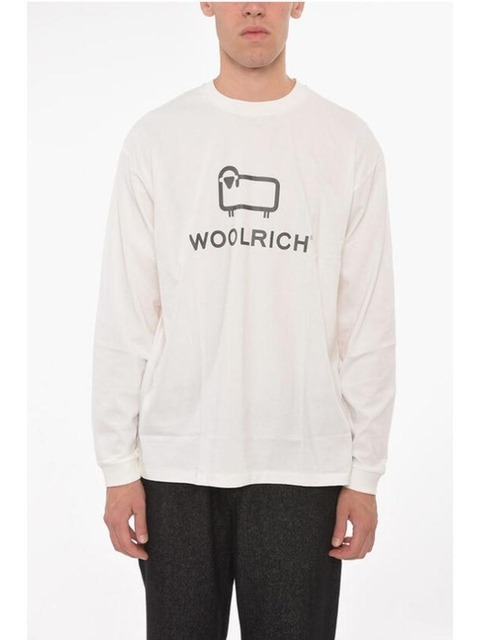

In [210]:
Image.open(inhovation_Dataset(Dataset_path,'train', transform = None).all_data[5000])

# ResNet 50 Architecture 구성

In [211]:
# import resnet
import torchvision.models.resnet as resnet
import torch.nn as nn
import torch.optim as optim

# 미리 정의
conv1x1=resnet.conv1x1
Bottleneck = resnet.Bottleneck
BasicBlock= resnet.BasicBlock

In [212]:
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000, zero_init_residual=True):
        super(ResNet, self).__init__()
        self.inplanes = 32 # conv1에서 나올 채널의 차원 -> 이미지넷보다 작은 데이터이므로 32로 조정

        # inputs = 3x224x224 -> 3x128x128로 바뀜
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False) # 마찬가지로 전부 사이즈 조정
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 32, layers[0], stride=1) # 3 반복
        self.layer2 = self._make_layer(block, 64, layers[1], stride=2) # 4 반복
        self.layer3 = self._make_layer(block, 128, layers[2], stride=2) # 6 반복
        self.layer4 = self._make_layer(block, 256, layers[3], stride=2) # 3 반복
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)

    def _make_layer(self, block, planes, blocks, stride=1): # planes -> 입력되는 채널 수
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion: 
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        # input [32, 128, 128] -> [C ,H, W]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        #x.shape =[32, 64, 64]

        x = self.layer1(x)
        #x.shape =[128, 64, 64]
        x = self.layer2(x)
        #x.shape =[256, 32, 32]
        x = self.layer3(x)
        #x.shape =[512, 16, 16]
        x = self.layer4(x)
        #x.shape =[1024, 8, 8]
        
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [213]:
import torch.nn as nn
import time

# Define the necessary blocks and functions for ResNet

'''
def conv1x1(in_planes, out_planes, stride=1):
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv1x1(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv1x1(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = conv1x1(inplanes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = conv1x1(planes, planes * self.expansion)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


# Dummy 'resnet' module for the provided code
class DummyResNetModule:
    Bottleneck = Bottleneck

resnet = DummyResNetModule()
'''

# Now, let's measure the time taken to execute the provided line of code
start_time = time.time()

resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 9, True).to(device)
end_time = time.time()
elapsed_time = end_time - start_time

elapsed_time

0.10445857048034668

In [214]:
# resnet50 = ResNet(resnet.Bottleneck, [3, 4, 6, 3], 3, True).to(device) 
# resnet50
# 1(conv1) + 9(layer1) + 12(layer2) + 18(layer3) + 9(layer4) +1(fc)= ResNet50

In [215]:
# !pip install torchsummary

In [216]:
# 출력 tensor가 맞는지 확인

from torchsummary import summary
summary(resnet50, input_size=(3, 128, 128), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             864
       BatchNorm2d-2         [-1, 32, 128, 128]              64
              ReLU-3         [-1, 32, 128, 128]               0
         MaxPool2d-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 32, 64, 64]           1,024
       BatchNorm2d-6           [-1, 32, 64, 64]              64
              ReLU-7           [-1, 32, 64, 64]               0
            Conv2d-8           [-1, 32, 64, 64]           9,216
       BatchNorm2d-9           [-1, 32, 64, 64]              64
             ReLU-10           [-1, 32, 64, 64]               0
           Conv2d-11          [-1, 128, 64, 64]           4,096
      BatchNorm2d-12          [-1, 128, 64, 64]             256
           Conv2d-13          [-1, 128, 64, 64]           4,096
      BatchNorm2d-14          [-1, 128,

In [217]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
     

torch.Size([32, 3, 3, 3])


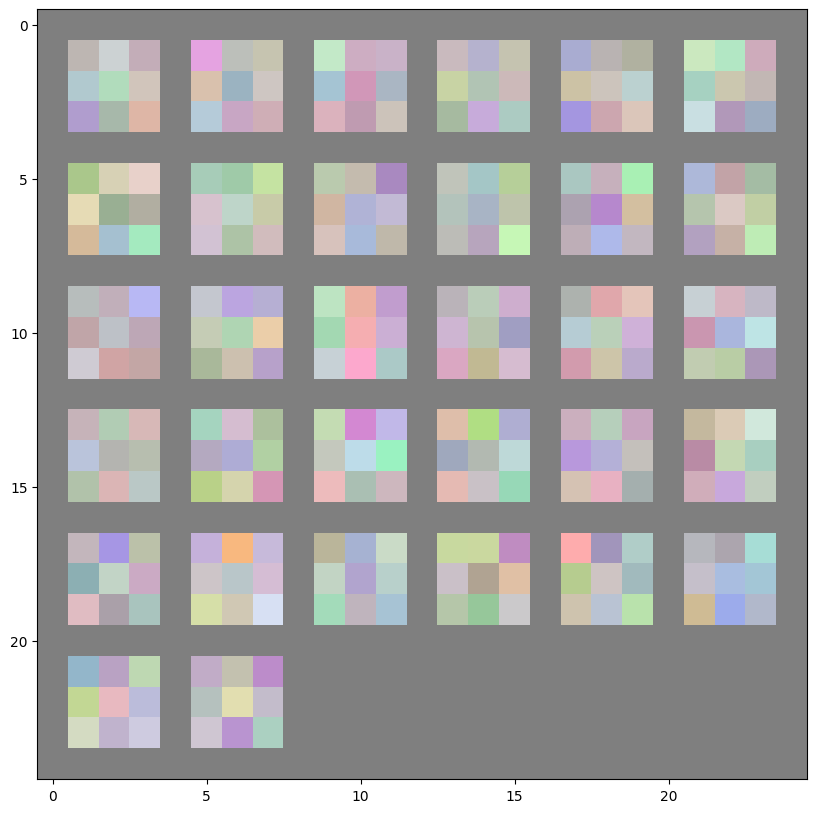

In [218]:
# 첫 번째 layer의 filter를 확인 (=가중치 확인) -> 나중에 학습을 완료한 후의 filter도 확인하기
for w in resnet50.parameters():
    w = w.data.cpu()
    print(w.shape)
    break

# 가중치 renormalization
min_w = torch.min(w)
w1 = (-1/(2 * min_w)) * w + 0.5

# make grid to display it
grid_size = len(w1)
x_grid = [w1[i] for i in range(grid_size)]
x_grid = torchvision.utils.make_grid(x_grid, nrow=6, padding=1)

plt.figure(figsize=(10, 10))
imshow(x_grid)

In [219]:
# config 모델 파라미터 인자를 만들기위한 클래스
class Config:
  def __init__(self, **kwargs):
    for key, value in kwargs.items():
      setattr(self, key, value)

In [220]:
lr = 0.001 
optimizer = 'Adam'

In [221]:
# 파라미터 클래스
config = Config(
    trainloader = train_loader,
    testloader = test_loader,
    model = resnet50,
    device = device,
    optimizer = torch.optim.Adam(resnet50.parameters(), lr=lr),
    criterion= nn.CrossEntropyLoss().to(device),
    globaliter = 0
)

In [222]:
class train_test():
    def __init__(self, config):
        # 파라미터 인자
        self.trainloader = config.trainloader
        self.testloader = config.testloader
        self.model = config.model
        self.device = config.device
        self.optimizer = config.optimizer
        self.criterion = config.criterion
        self.globaliter = config.globaliter
        print(len(self.trainloader))

    def train(self, epochs, log_interval):
        self.model.train()
        total_correct = 0
        total_data = 0
        for epoch in range(1, epochs + 1):  # epochs 루프
            running_loss = 0.0
            lr_sche.step()
            for i, data in enumerate(self.trainloader, 0): # batch 루프
                # get the inputs
                self.globaliter += 1
                inputs, labels = data # input data, label 분리
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                # zero the parameter gradients
                self.optimizer.zero_grad() 

                # forward + backward + optimize
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                running_loss += loss.item()

                # 30 iteration마다 acc & loss 출력
                if i % log_interval == log_interval - 1:
                    print('Train Epoch: {} [{}/{} ({:.0f}%)]\tlearningLoss: {:.6f}\twhole_loss: {:.6f} '.format(
                        epoch, i*len(inputs), len(self.trainloader.dataset),
                        100. * i*len(inputs) / len(self.trainloader.dataset), 
                        running_loss / log_interval,
                        loss.item()))
                    running_loss = 0.0

            with torch.no_grad():
                self.model.eval()
                correct = 0
                total = 0
                test_loss = 0
                for k, data in enumerate(self.testloader, 0):
                    images, labels = data
                    images = images.to(self.device)
                    labels = labels.to(self.device)
                    outputs = self.model(images)

                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    test_loss += self.criterion(outputs, labels).item()

                total_correct += correct
                total_data += total

                print('\nEpoch {} - Test set : Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                    epoch, test_loss, correct, total, 100 * correct/total))

        average_accuracy = 100 * total_correct / total_data
        print('\nFinal Average Accuracy across all epochs: {:.2f}%\n'.format(average_accuracy))

    print('Finished Training')


Finished Training


In [223]:
ready_to_train=train_test(config)

34


In [224]:
lr_sche = optim.lr_scheduler.StepLR(config.optimizer, step_size=10000, gamma=0.5) # 20 step마다 lr조정
epochs = 3
log_interval = 175

ready_to_train.train(epochs, log_interval)


Epoch 1 - Test set : Average loss: 15.7863, Accuracy: 860/2141 (40%)


Epoch 2 - Test set : Average loss: 10.6124, Accuracy: 1172/2141 (55%)


Epoch 3 - Test set : Average loss: 11.4268, Accuracy: 1146/2141 (54%)


Final Average Accuracy across all epochs: 49.48%

